In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras_preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, ReLU, LeakyReLU, SimpleRNN
from keras.optimizers import SGD
from konlpy.tag import Okt 

In [97]:
csv_data1 = pd.read_csv('movie.csv', encoding='utf8').dropna()
csv_data2 = pd.read_csv('movie2.csv', encoding='utf8').dropna()

csv_data = csv_data1.append(csv_data2)
                        
csv_data = csv_data[csv_data.평점 != 5]
csv_data = csv_data[csv_data.평점 != 6]
csv_data = csv_data[csv_data.평점 != 7]
csv_data = csv_data[csv_data.평점 != 8]
csv_data['평점'] = csv_data['평점'].apply(lambda x: 1 if x>=9 else 0)
csv_data.reset_index(drop=True, inplace=True)

print(len(csv_data1))
print(len(csv_data2))
print(len(csv_data.drop_duplicates(['번호'], keep='first')))
print(len(csv_data))


csv_data = csv_data[:8000]

9817
9805
15304
15304


In [84]:
okt = Okt()
token = [okt.pos(csv_data['평가'][i], stem=True, norm=True) for i in range(len(csv_data))]

In [85]:
tokenizer = Tokenizer()

max_len = 0
x_data = []
for t in token:
    tmp = [[i[0]+'/'+i[1]] for i in np.array(t)]
    x_data.append(tmp)
    if max_len < len(tmp):
        max_len = len(tmp)
    tokenizer.fit_on_texts(tmp)
print(len(tokenizer.word_index))
print(max_len)

10411
67


In [86]:
x_data_seq = []
for x in x_data:
    x_data_seq.append(tokenizer.texts_to_sequences(x))

In [87]:
x_pad_data = sequence.pad_sequences(x_data_seq, maxlen=max_len)

In [88]:
# x_train = np.asarray(x_pad_data, np.float32)/len(tokenizer.word_index)
x_train = x_pad_data

In [100]:
# y_train = []
# for d in csv_data['평점']:
#     if d == 0:
#         y_train.append([1,0])
#     else:
#         y_train.append([0,1])
        
y_train = []
for d in csv_data['평점']:
    if d == 0:
        y_train.append([0])
    else:
        y_train.append([1])

In [101]:
x_train_ = x_train.reshape((-1,max_len))
y_train_ = np.array(y_train).reshape((-1,1))
print(x_train_.shape)
print(y_train_.shape)

(8000, 67)
(8000, 1)


In [102]:
np.random.seed(0)
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, len(y_train_), input_length=max_len))
model.add(LSTM(max_len, input_shape=(max_len,1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
history = model.fit(x_train_, y_train_, epochs=3, verbose=1, validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/3
6400/6400 [==============================] - 299s 47ms/step - loss: 0.3625 - acc: 0.8434 - val_loss: 0.3149 - val_acc: 0.8694
Epoch 2/3
6400/6400 [==============================] - 304s 47ms/step - loss: 0.1441 - acc: 0.9509 - val_loss: 0.4013 - val_acc: 0.8600
Epoch 3/3
6400/6400 [==============================] - 317s 50ms/step - loss: 0.0481 - acc: 0.9847 - val_loss: 0.4882 - val_acc: 0.8644


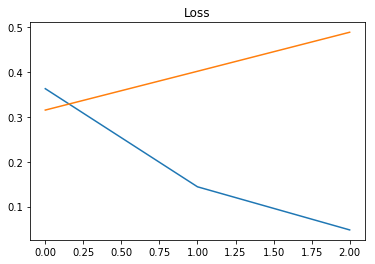

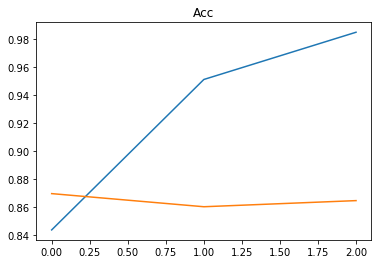

In [104]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.show()
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Acc")
plt.show()

In [105]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     a = pickle.load(handle)

In [106]:
predictions = model.predict(x_train_)
print(predictions)
for i in range(len(predictions)):
    if predictions[i,0] > 0.5:
        print(1, end=' ')
    else:
        print(0, end=' ')
    print(csv_data['평가'][i])

[[0.00307599]
 [0.99257624]
 [0.99916875]
 ...
 [0.9995022 ]
 [0.84767056]
 [0.99719954]]
0 와 극단적인 페미영화... 경찰이 잡게 불면 되지 총으로 다 쏴죽이고 대한민국 법이 약자에 블리히고 머 어째?..
1 마지막엔 눈물이 났다. 다큐멘터리가 더 정확한건 어쩔수없는거 아닐까... 하는 생각도 들었다.
1 연출력과 연기력 최고의 영화
1 10년 전쯤 우연히 보고.. 감동 받았는데.. 문득 생각나서 다시 봐도 감동이 여전한 영화
1 말이 필요없고이런영화 필요하다. 너네 둘이니까 가능했다 쵝오!!
1 저는 나름 잘 봤어요. 배경도 아름답고 자극적이지 않아 좋았어요.
1 그래픽디진다 진짜..어떻게 이렇게 만들수가 있지.. 잡설도 없고 무조건 강강강 액션...알리타2야 나와라 노바 쥑이러 가자~
1 정말 연기들잘하시네요 마지막 인형동영상이 많이 슬픔니다... 남잔데 눈물이 주르륵나네요 잘봤습니다. 다들 즐거운하루보내세요
1 기대없이 봤다.  이정도면 9점! 망한걸로 알고있는데 아쉽네
0 주인공 고딩이라 찌질하다, 이디아 넘기려면 퓨리랑 상의라도 하던지. 증강현실기계를 눈에 착용도  안하고 인식한다는 말도 안되는 이야기에, 영사기로 화면을 보내는대, 사람마다 보는 시점이 다른대 그게 인식이 된다고 우긴디ㅣ
1 아무생각없이 봐도 좋은 영화입니다
1 재밌어요 스파이더맨 너므 죠아 ㅠㅠ
1 한 사람의 일생을 편견때문에 잃은 감동적인 영화
0 결말이 정말 고작 이렇게까지 허무...;;해리포터는 연기를 참 잘하지만 영화는..뭔가..많이..허전하고 부족하고 허무하고 ..영상미는좋다...5점주려다 언니의 점수 2점을 반영하여 4점을주겠다
0 진짜 이딴 영화를 IMAX로 돈날려가며 본 내잘못이다
1 영화를 다보고 나서 저는 그만 물에 잠기고 말았습니다. 그 물은 다름 아닌 저의 눈물이었습니다. 저는 위로가 필요할때면 항상 이 영화를 찾습니다.
1 역대급 영화 최고의 영화
1 피터 찌리릿의 활약이 돋보이고 멋있는

0 별로 재미도 없더만... 기생충이 훨 낫더라
1 모든 면에서 쩔어주는 영화인데 너무 저평가.
1 보기전에는 별로 재미없을거 같았는데 영화관에서 보면 진짜 소름이 쫙 돋는다는 얘기를 듣고 오늘 곧장가서 보고왔는데 진짜 너무 명작이에요 나중에 늙어서도 볼래요 ㅎㅎ
1 진짜 최고 마블은 잘 안봐서 앤드게임 안보고 보면 노잼일줄알았는데 앤드게임 안보고 봐도 재밌었고 2시간20분 정도 되는데 시간 순삭 ㅜㅜ 그리고 톰 홀랜드 당신은 최고의 스파이더맨 진짜 이거 보고 안반하면 사람 아님 ㅜㅜㅜ
1 감정의 농도가 굉장히 깊은 드라마 거기에 매장면 소름돋게하는 레이디가가의 목소리
0 너무 유치하고 재미없었다....
1 오늘도 딸과 함께 잘 봤습니다. 뮤지컬 극장에 다녀온 기분...딸은 벌써 두 번째 봅니다 ㅎ ㅎ ㅎ
1 쿠키영상 2개입니다 참고하세영
1 Sopia : He shot my dog! John : ...I get it.
0 너무 뻔한 전개에 임팩트 없는 내용... 평정 알바들 되게 많네요. 8점대는 아닌거 같아서 1점 드립니다만 주인공의 스타일과 영상미는 좋았어요
1 아무 생각없이 봤다가 완전 대박~!  감독, 출연진, 박지영  모두 최고 ~~ 이런 영화가 진짜 영화죠~
1 홀랜드 연기좋네요 피터의 성장기영화 스타크의 피터사랑이 돋보이네요
1 박평식 10 ㅅHㄲ| ㅋㅋㅋㅋ 좀 죽어라... 제발
1 수작이다. 특히 카메라 구도가 마음에 들었다.딱 상받을만한 영화
1 인생영화입니다..정말 최고의 영화네요
1 영화 도입부, 에이러~비언 나~잇트를 부르는 윌스미스의 현란한 혀놀림에서부터 관객들은 영화에 홀려들게 된다.
1 웃고 웃고 또 웃고 감사합니다
1 결국 인생역전 했지만 그전까지는 죽어라 열심히 살아도 희망이 없어 보이는데 내인생은 저렇게 열심히살지않는데도 저인생보다 나은걸까아니, 가드너의 힘든 과거는 인생역전의 발판이 될 거름이였고 내 인생은 현실에 안주함에 따라 속편히 세상 한탄만 하는걸지도
1 스파이더맨 너무 귀엽고 귀여움 ㅠㅠ
1 와 방금 드디어 보고 나

0 속지 마세요 킬링타임으로도 안됨정 보고 싶으면 초반 5분만 보세요
1 너무 마음 아려오면서도 따뜻해지는 뜨거운 눈물이 나는 영화.
1 최고네 정말 최고다. 이런 사람들만 있었으면 좋겠다
1 어른들이 정말 반성하고 관심을 많이 가져야 합니다. 이보다 중요한 건 없을 것 같네요.
1 말이 필요없다 내 인생영화.
0 공작원이라고 써붙이고댕긴다 그래
1 믿고 보는 마블. 믿고 보는 스파이더맨입니다.
1 저예산 영화입니다. 음... 저 또한 부모님의 이혼을 경험한 사람인데요. 제 가슴을 후벼파는 대목이 많네요. 또한 여사친이라는 든든한 버팀목도 부럽고 주위에 좋은 사람이 많은 것도 저의 상황과 너무 비슷해서 곧 결혼할 여자친구와 눈물 흘리며 봤습니다.
1 이런 감독님, 배우들의 영화를 볼수 있는것에 정말 감사한다.
0 정치영화 안봐ㅋㅋㅋ 안본다
0 원작을 망치는 참신한 방식.
1 와 이제야 봤는데 엔딩 진짜 전형적인 결말이 아니라서 너무 좋았다. 갓명작. 시대를 잘못탄듯
1 완전 꿀잼이었어요오오오오
1 마지막에 기우의 바램이 이루어지지 않을 것 같지만 이뤄졌음 좋겠다. 그냥. 그랬음 좋겠다.
1 개인적으로. 엔드게임보다위
1 토비 맥과이어의 스파이더맨이 최곤줄 알았지만, 톰홀랜드...진짜가 나타났다
0 존 이제 볼일없을테니 은퇴해
0 원래 0점인데 짠해서 1점 줌
1 우오  역시 도라지 담배네
1 7세9세 아이들과 함께 봤습니다.너무 재미있었고 아이들도 긴시간동안 집중하며 잘 보더군요. 노래부를때 약간 지루한 감이 있었지만...동심을 일깨워주고 지혜로움을 알려줄 수 있었던것 같네요.
1 .잘봤습니다가족의중요성
1 어벤져스에 대한 헌정  + 스파이더맨의.시대 개막!
1 우연히 TV에서 봤는데 너무 좋은 영화
1 반전에 반전이네 스파이더맨 너무 재밌었고 톰 홀랜드 너무 멋지다 미스테리오도 멋져버리네ㅜㅠ
1 개재밌어요 다시 보라고 해도 다시 볼 영화입니다
1 보니의 행동이 딱 아이들 행동이지 뭐.
1 아이들이랑 재밌게 보았네요^^최고였어요
1 너무 재밌어요!강력 추천합니

0 ..재미가읍ㄷㅏ....
1 미스테리오 환상 씬 진심 숨막혔었음 연출 장난아니였음 내가 환상에 걸린 듯한 기분까지 들었음 묘비석 떨어지고 그 단 2초간 정적이 잊혀지질 않음
0 아따 일본불매 운동은 찬성하지만 스파이더맨은 봐야된당께?ㅋㅋ OO들
0 공포영화인지 성범죄야동인지 ㅉ
0 2.22 내가 맞춰줄께  기다려바아
1 너무 잼나고 빵터져요.요런 코미디 넘 좋아요.ㅎㅎ
1 재밌으면 된거지....
1 최고의 영화 중 하나입니다
1 위대한 예술가들 대부분은 동성애자 혹은 양성애자였다.
1 가난과 부자의 차이를 보았어요상받을만 하네요
1 질펀한 바닥에서 신발을 갈아신던 모습을 잊을 수가 없다.
1 애니에서 실사화한거 중에 최고입니다~~~^^
1 이영화는 꼭 봐야됨~~~~
0 뭐냐 이게! ;U 완전 양산형 공포영화 다 됐구만. 단물 다 빠진 컨저링 유니버스
1 나홀로집에 스파이더맨
1 윌스미스의 연기력이 정말 대단하네요 아이들도 너무 좋아하고 어른들도 즐거웠어요 한국어더빙보다 원본이 더 좋았어요
1 CG가 진짜 와 시ㅂ  할정도로 놀라워서 대박인 영화하지만 역시 엔겜 다음이라 임펙트가 상대적으로 부족한것도 없지않아 잇지... 그래도 굳굳굳
1 꿈과 이상을 잊어버리고 사는 나에게 찾아온 묵직한 한방
0 알바들 좀 어케해봐라ㅋㅋ액션신 쓸데없이 잔인하고 너무 길어져서 지루함+개연성 1도없는 스토리 진짜 올해본 최악의 망작ㅋㅋ연말에 최악의망작 TOP3에 꼽을듯
1 재밌었어요 2탄도 나와라
1 토니파커 넘 귀여움ㅜㅜㅜ 기대이상
1 피터 파커. 여엿한 어벤져가 되는 영화
1 존잼! 디즈니 실사영화 중 Top.1 일듯
1 그냥 재밌음 ㅋㅋㅋ 유해진의 주연으로써의 가능성을 여실히 보여준 영화 ㅎㅎ
1 얘들아 토이스토리 300만은 넘기자.. 스파이더맨,알라딘 땜씨 생각보다 성적이 부진하네 ㅠ
1 어벤져스의 끝판왕..포에버어벤져스
1 최고!!!~상영관부족이 아쉬워요
1 아이가 보고싶어해서 갔다왔습니다.생각보다 잼있어서 다들 즐겁게 웃었습니다.
1 역대급 스파이더맨!!!!스파이더맨 시

0 현재 나라 망하게 된 OO점인 영화
1 액션영화는 이래야된다. 정말 시간가는줄 몰랐다
1 작품을 보고 나면 나도 자연스럽게 아이같은 순수한 마음을 가지게 되는 몇 안되는 진정한 작품 ㅜㅜ
1 인생명화..언제봐도 안질리고 또 보게됨..
1 정말 스파이더맨 짱!!
1 너무재미잇다!!!!너무 귀여워어ㅓㅓ♥
1 최고ㅠㅠ내가왜이걸지금봤지!!
1 진짜 사람을 웃기고 울리는 힐링타임영화
1 개재밌음미침..오우예스
1 알라딘 디즈니원작을 뛰어넘게해준 윌스미스와 자스민 에게 박수를
1 이거 영화소개가 스포일러네 미친...!! 읽지마
1 너무재밌고아아아아이어
0 그냥... 끝까지 본 사람들에게 격려를...
1 토니가 아연맨 마크2 개발할 때 나온 브금에 토니처럼 홀로그램에 손가락 튕기면서 수트 튜닝할때...뭉클...
1 추억돋는..각박한요즘세상.저런알콩달콩한편한드라마로만들어져도좋을것같아요.
0 관객수 425명 ㅋㅋㅋ 슬프네요
1 졸잼입니다ㅜㅜㅜ톰홀랜드 흥해라
0 진짜 제발. 이런 영화 만들지 마세요
0 소니....ㅎ ㅏ 일본불매 영화는 안하나요
0 결론은 불륜천하 내로남불
0 재미없음 오락용영화 보는내내 반지의제왕 재개봉이나 했으면 좋겠단 생각함
1 i love you 3000
1 최고의 스파이더맨 영화
1 피터가 점점 성숙해져가는 과정을 볼 수 있는 영화
1 가까운 미래에 더욱 갈망하게 될 인간 본연의 이야기들
0 상영관수를 보면 알수있다 평점은 높은데 입소문이 안나기때문에 상영관수,관객수 다 저조해요 그냥 쏘쏘
1 책도 한번 읽어봐야겠네요 추천합니다.!
1 하.. 최고다 10점.
1 이 영화 짧게 표현하자면와~최고다 좋았어요
1 우디랑 애들 다시 만나는거 보려면 또 10년 기다려야되냐?
1 알라딘이 지니에게 자유를 줄 때,최근 뭔기 쫓기듯이 살어가는 나에게 진정 소중한 것이 무엇인지 새삼 알게해 준 영화.
0 드릅게 재미업다 초등학생도 안무서워할거같음 ㅎㅎ
1 기대안하고 봤는데 스파이더맨이 성장하는 스토리를 짜임새있게 잘 보여준것같다 역시마블!!
1 순수함을 찬양하면서 

1 한 컷 한 컷 넘  잼났어요  기분 좋아지는  영화^^
1 난 너무 좋았는데ㅠ 옛날 생각나서 너무 좋았어...
1 영화를 아쉽게 본건 이해하는데 그렇다고 재미있게 본 사람들 이해못한다고 하는건 좀 그르네여
1 어린 피터가 히어로와 일상 속에서 겪는 딜레마를 정말 잘표현, 토니에 대한 그리움 그리고 토니의 피터사랑을 너무나 잘 표현한 영화라고 생각합니다
1 정말개꿍잼입니다ㅎㄹ
1 애니메이션을 기대하고 보면 안된다.오히려 알아보기 힘들었던 주인공들의 표정들 속에서 희미하게 느껴졌던 감정과 미세한 눈빛의 흔들림이 내 마음을 더 흔들었다. 최고...
1 와우 우리조카꿈인데 바꿔야할듯
1 존파브로는 정글북 부터 맘에 안들었다.
1 우디.. 이제 보내줄게 행복해
1 라이온킹..뭐야 돌려줘요...적당히 만들지 너무 잘만들어서 문제..지독한 원리원칙주의자가 한치의 오차도 없이 만들어 낸 2시간짜리 내셔널지오그래픽
1 너무재밌었던것같아요^^윌스미스가 진짜 캐리한것같아요 노래도 다 좋고><
1 기다릴수가 없어서 조조로 보고 옴... 애니메이션의 몇몇 장면들을 어떻게 실사화 할지 궁금했었는데 역시 디즈니가 디즈니 했다는 말밖에 안나오고 노래는 여전히 소름돋았다.
1 사실 내용은 어릴때 보던내용이라 다음내용이 궁금하진 않았으나, 그래픽이 정말 실제와 같았고 OST가 좋았습니다.
1 부족한 부분 1도 없이 너무 좋았어요.한달전 세렝게티 다녀왔는데 정말 세렝게티 모습보는듯했어요!!! 영화끝나고 박수치고 나왔습니다!!
1 관객수가 아쉬운 영화,,
1 얼마전 페이스북에서 한국에서 유학중인 블랙아메리카노가 한국인들에게 실험영상을찍은걸봤다 한국인들에게 흑형, 흑누나,깜둥이가무슨뜻인지 물어보는 ㅠㅠ어제 이 영화를보고 다시한번 인종차별의 부끄러움이밀려온다 영화 "헬프"이후에
0 뭐랄까 진부하고 지루했고 뻔했다
0 별 반도 아깝네 이걸 영화라고 만들었냐?
1 티몬과품바때문에 중간중간 사람들 다터짐니다 ㅋㅋㅋ이번영화는 심바보다 품바가 인상깊었습니다..
1 223223223223
1 아니 이정도면

In [107]:
def prediction(text):
    t = okt.pos(text, stem=True, norm=True)
    s = tokenizer.texts_to_sequences([[i[0]+'/'+i[1]] for i in np.array(t)])
    
#   0 으로 채우기
#     sn = [n if n!=[] else [0] for n in s]

#   0 제거
    sn = []
    for n in s: 
        if n != []: 
            sn.append(n)
            
    p = sequence.pad_sequences([sn], maxlen=max_len)
    x = np.array(p).reshape((1,-1))
    y = model.predict(x)
    return y[0,0], sn

def processing(text='.'):
    y, sn = prediction(text)
    print('=================================================')
    print(sn)
    if y < 0.5:
        print('"%s"는\n%f의 확률로 부정적입니다.'%(text, (1-y)*100))
    else:
        print('"%s"는\n%f의 확률로 긍정적입니다.'%(text, y*100))
    print('=================================================')

processing('코딩 존나오래하니까 대가리 터질꺼같다 시발 ...')
processing('코딩은 무슨 ㅅㅂ 뺑이나 치셈')
processing('앗차차 내가 무슨소릴 코딩이 최고지 내일도 코딩해야징~~')
processing('여자친구 만들어야지')
processing('가끔 그녀를 생각할 때면 나도 모르게 웃음이 나오곤 한다')
processing('가끔 그녀를 생각할 때면 나도 모르게 눈물이 나오곤 한다')

[[684], [762], [4], [2720], [783], [32], [16]]
"코딩 존나오래하니까 대가리 터질꺼같다 시발 ..."는
52.855742의 확률로 부정적입니다.
[[14], [441], [1930], [293], [346]]
"코딩은 무슨 ㅅㅂ 뺑이나 치셈"는
99.082288의 확률로 부정적입니다.
[[4260], [95], [6], [991], [588], [5], [26], [190], [1647], [12], [4], [2457], [180]]
"앗차차 내가 무슨소릴 코딩이 최고지 내일도 코딩해야징~~"는
99.973291의 확률로 긍정적입니다.
[[1897], [50]]
"여자친구 만들어야지"는
92.398334의 확률로 긍정적입니다.
[[2409], [2750], [19], [52], [4], [57], [206], [135], [93], [611], [5], [38], [4]]
"가끔 그녀를 생각할 때면 나도 모르게 웃음이 나오곤 한다"는
98.768216의 확률로 긍정적입니다.
[[2409], [2750], [19], [52], [4], [57], [206], [135], [93], [175], [5], [38], [4]]
"가끔 그녀를 생각할 때면 나도 모르게 눈물이 나오곤 한다"는
99.876440의 확률로 긍정적입니다.


In [ ]:
# 모델 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("save")

In [6]:
# 모델 로드
from keras.models import model_from_json 

json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# compile
# loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# loaded_model_history = model.fit(x_train_, y_train_, epochs=20, verbose=1)

W0718 07:48:54.073545 4660368832 deprecation_wrapper.py:119] From /Users/lunab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 07:48:54.088603 4660368832 deprecation_wrapper.py:119] From /Users/lunab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 07:48:54.102164 4660368832 deprecation_wrapper.py:119] From /Users/lunab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 07:48:54.453232 4660368832 deprecation_wrapper.py:119] From /Users/lunab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W071

Loaded model from disk


In [140]:
print(1)

1
